In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('energy_consumption_dataset.csv', parse_dates=['Date'])

In [3]:
data.head()

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1460 non-null   datetime64[ns]
 1   Energy Consumption  1460 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.9 KB


In [5]:
data.describe()

,Date,Energy Consumption
count,1460,1460.000000
mean,2021-12-30 12:00:00.000000256,350.451726
min,2020-01-01 00:00:00,265.886301
25%,2020-12-30 18:00:00,324.913290
50%,2021-12-30 12:00:00,349.962555
75%,2022-12-30 06:00:00,375.550666
max,2023-12-30 00:00:00,424.172656
std,NaN,31.566215


In [6]:
# Extract day, month, and year from the Date column
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data.drop('Date', axis=1)

,Energy Consumption,Day,Month,Year
0,305.311409,1,1,2020
1,299.374329,2,1,2020
2,307.646359,3,1,2020
3,316.811967,4,1,2020
4,299.651923,5,1,2020
...,...,...,...,...
1455,380.398916,26,12,2023
1456,405.951747,27,12,2023
1457,402.642110,28,12,2023
1458,412.140555,29,12,2023


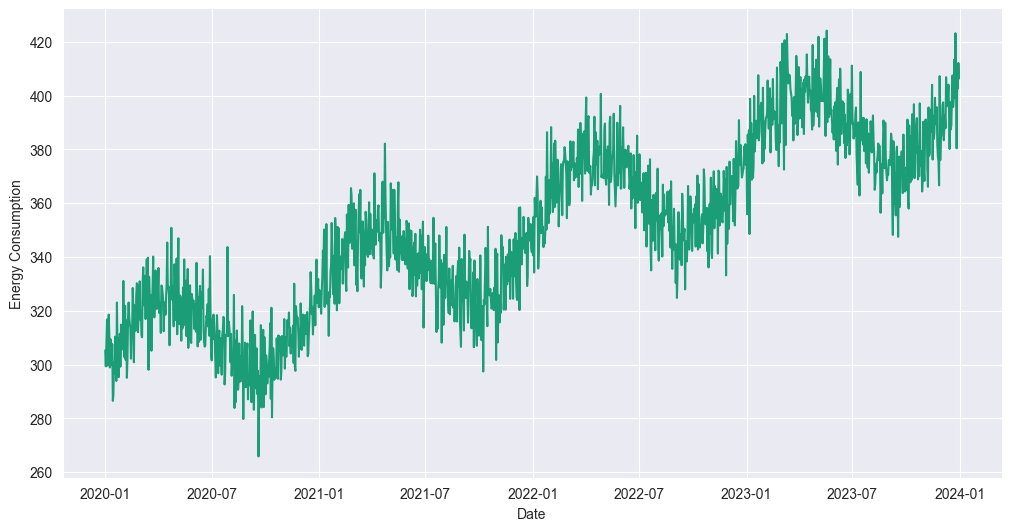

In [7]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Energy Consumption']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Energy Consumption')

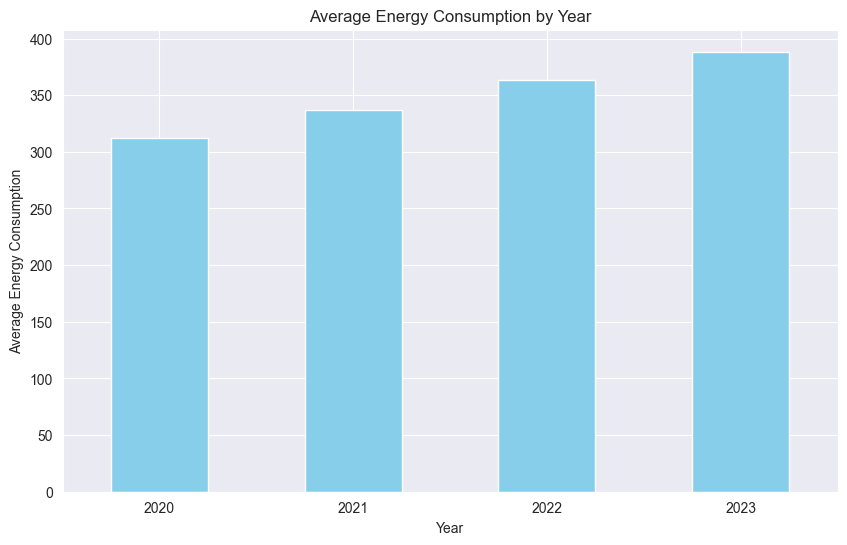

In [8]:
# Group by Year and calculate the average energy consumption
Year_avg_consumption = data.groupby('Year')['Energy Consumption'].mean()
# Optionally, plot the Year average energy consumption
plt.figure(figsize=(10,6))
Year_avg_consumption.plot(kind='bar', color='skyblue')
plt.title('Average Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Average Energy Consumption')
plt.xticks(rotation=0)
plt.show()

# Model

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Energy Consumption'] = scaler.fit_transform(data['Energy Consumption'].values.reshape(-1, 1))

In [10]:
data

,Date,Energy Consumption,Day,Month,Year
0,2020-01-01,0.249075,1,1,2020
1,2020-01-02,0.211566,2,1,2020
2,2020-01-03,0.263826,3,1,2020
3,2020-01-04,0.321731,4,1,2020
4,2020-01-05,0.213320,5,1,2020
...,...,...,...,...,...
1455,2023-12-26,0.723452,26,12,2023
1456,2023-12-27,0.884886,27,12,2023
1457,2023-12-28,0.863977,28,12,2023
1458,2023-12-29,0.923985,29,12,2023


## time_steps=7

In [11]:
# Create sequences of past values to predict future value
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [12]:
time_steps = 7
X, y = create_sequences(data['Energy Consumption'].values, time_steps)

In [13]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
X_train

array([[0.24907458, 0.21156611, 0.26382601, ..., 0.21331985, 0.21591921,
        0.33307501],
       [0.21156611, 0.26382601, 0.32173125, ..., 0.21591921, 0.33307501,
        0.28437955],
       [0.26382601, 0.32173125, 0.21331985, ..., 0.33307501, 0.28437955,
        0.20882061],
       ...,
       [0.80956431, 0.67358156, 0.97758554, ..., 0.73153033, 0.90134686,
        0.99210813],
       [0.67358156, 0.97758554, 0.74639488, ..., 0.90134686, 0.99210813,
        0.92661999],
       [0.97758554, 0.74639488, 0.73153033, ..., 0.99210813, 0.92661999,
        0.87595049]])

In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError
import matplotlib.pyplot as plt

In [17]:
# Define the model
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(time_steps, 1)),
    Dense(1)
])
# Compile the model with additional metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30


/Users/marouandgh/IdeaProjects/Deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0813 - mean_absolute_error: 0.2231 - val_loss: 0.0088 - val_mean_absolute_error: 0.0760
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0600 - val_loss: 0.0046 - val_mean_absolute_error: 0.0544
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0045 - val_mean_absolute_error: 0.0540
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0044 - val_mean_absolute_error: 0.0542
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mean_absolute_error: 0.0525 - val_loss: 0.0044 - val_mean_absolute_error: 0.0545
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0508 - val_loss: 0.0046 - val_mean_absolute_error: 0.0548
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0532 - val_loss: 0.0044 - val_mea

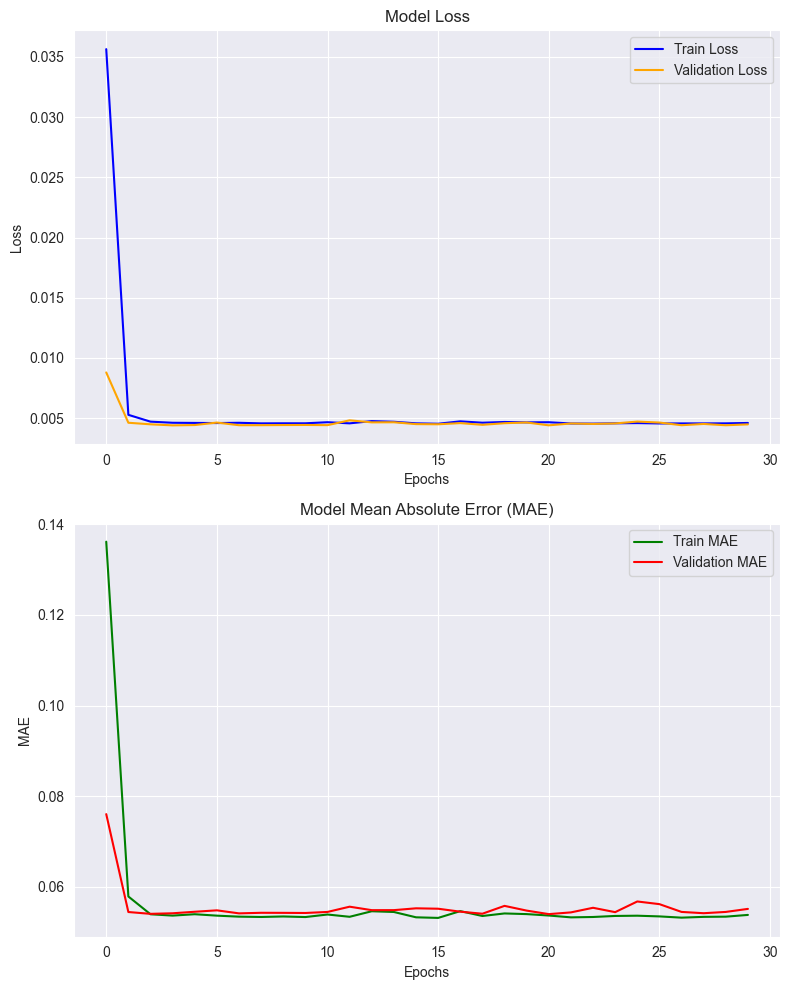

In [18]:
# Create a figure with two subplots for separate diagrams
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot loss
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Plot MAE
ax2.plot(history.history['mean_absolute_error'], label='Train MAE', color='green')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
ax2.set_title('Model Mean Absolute Error (MAE)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

## time_steps=10

In [19]:
# Create sequences of past values to predict future value
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [20]:
time_steps = 10
X, y = create_sequences(data['Energy Consumption'].values, time_steps)

In [21]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [25]:
# Define the model
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(time_steps, 1)),
    Dense(1)
])
# Compile the model with additional metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/Users/marouandgh/IdeaProjects/Deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0563 - mean_absolute_error: 0.1783 - val_loss: 0.0045 - val_mean_absolute_error: 0.0551
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0585 - val_loss: 0.0044 - val_mean_absolute_error: 0.0533
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0043 - val_mean_absolute_error: 0.0535
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0044 - val_mean_absolute_error: 0.0545
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - mean_absolute_error: 0.0537 - val_loss: 0.0045 - val_mean_absolute_error: 0.0549
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0044 - val_mean_absolute_error: 0.0543
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0537 - val_loss: 0.0043 - val_me

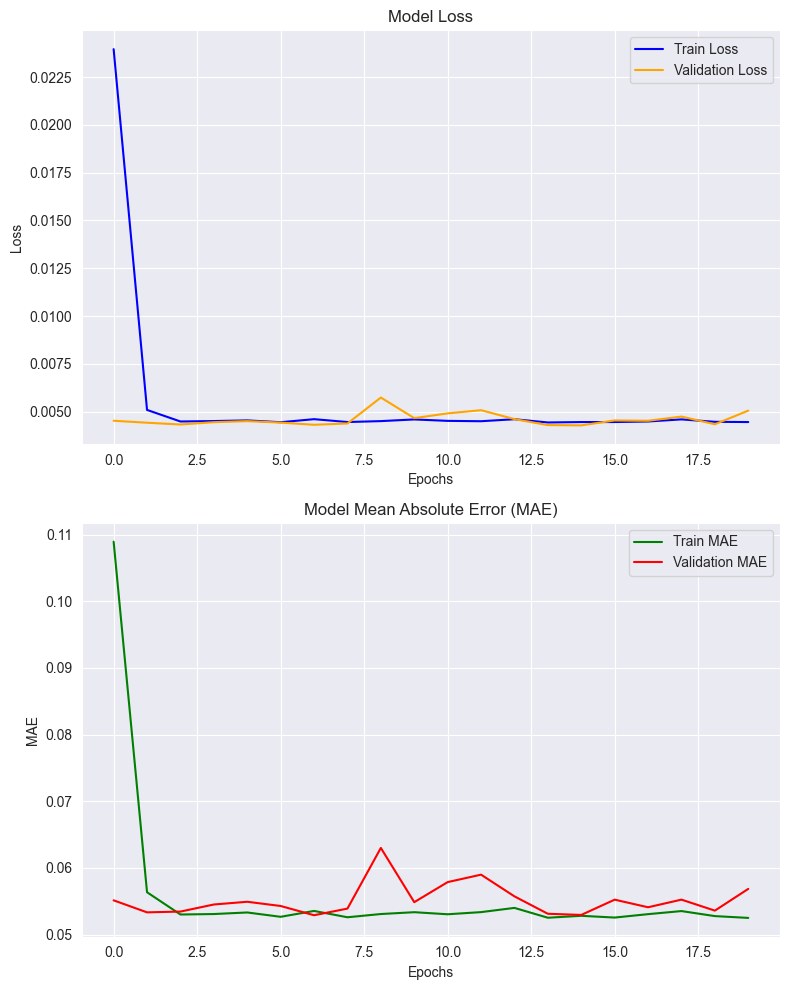

In [26]:
# Create a figure with two subplots for separate diagrams
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot loss
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Plot MAE
ax2.plot(history.history['mean_absolute_error'], label='Train MAE', color='green')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
ax2.set_title('Model Mean Absolute Error (MAE)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

## time_steps=12


In [27]:
# Create sequences of past values to predict future value
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [28]:
time_steps = 12
X, y = create_sequences(data['Energy Consumption'].values, time_steps)

In [29]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [30]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [31]:
# Define the model
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(time_steps, 1)),
    Dense(1)
])
# Compile the model with additional metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/Users/marouandgh/IdeaProjects/Deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1703 - val_loss: 0.0043 - val_mean_absolute_error: 0.0537
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0584 - val_loss: 0.0046 - val_mean_absolute_error: 0.0543
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0043 - val_mean_absolute_error: 0.0536
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - mean_absolute_error: 0.0518 - val_loss: 0.0049 - val_mean_absolute_error: 0.0576
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0045 - val_mean_absolute_error: 0.0549
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0050 - val_mean_absolute_error: 0.0582
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0523 - val_loss: 0.0080 - val_me

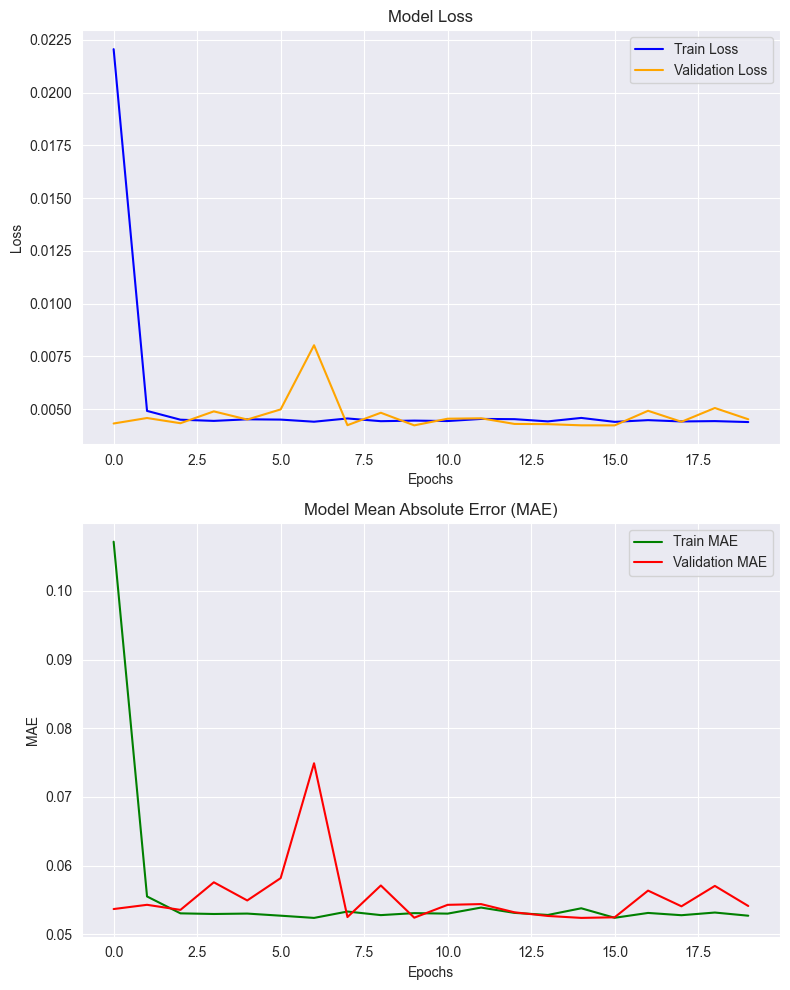

In [32]:
# Create a figure with two subplots for separate diagrams
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot loss
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Plot MAE
ax2.plot(history.history['mean_absolute_error'], label='Train MAE', color='green')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
ax2.set_title('Model Mean Absolute Error (MAE)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()